# Backtesting Introduction

This notebook intends to explain you how to use the `Backtester` class that `soam` provides by illustrating a simple and generic example.

### Database used
We will be using a database that stores information on Apple's and Tesla's stocks over a period of time.

In [1]:
from soam.workflow.time_series_extractor import TimeSeriesExtractor
from soam.workflow.forecaster import Forecaster
from soam.workflow import Backtester, Transformer, DummyDataFrameTransformer
from soam.models.prophet import SkProphet

from muttlib.dbconn import get_client
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

import logging, sys
logging.disable(sys.maxsize)

## Establish connection with the database and retrieve the pandas DataFrame we will use

We use the `SoaM` `TimeSeriesExtractor` to retrieve data from our `DataBase` and apply simple transformations to have the data ready for our forecasting model.

To see further information about the `TimeSeriesExtractor` check our [Time Series Extractor, Slicer and Store Introduction](https://gitlab.com/mutt_data/soam/-/blob/master/notebook/examples/extractor_slicer_store_example.ipynb).


In [2]:
sqlite_cfg = {
    "db_type": "sqlite",
    "database": "soam_quickstart.db"
}

sqlite_client = get_client(sqlite_cfg)[1]
extractor = TimeSeriesExtractor(db=sqlite_client, table_name='stock')
query={
    'columns': '*',
    'extra_where_conditions': ["symbol = 'AAPL'"],
    'dimensions': ['date']
    
}
df = extractor.run(build_query_kwargs = query)
df = df[['date', 'avg_price']]
df.rename(columns = {
    'date': 'ds',
    'avg_price': 'y'}, inplace = True)
df.ds = pd.to_datetime(df.ds)
df.head()

ds      y
0 2021-03-01  125.0
1 2021-03-02  126.0
2 2021-03-03  123.0
3 2021-03-04  121.0
4 2021-03-05  119.0

## Basic backtesting

We will use the built in `SkProphet` model to generate a forecasting model and measure it's performance over several points. Later, we will observe how the selected metrics distribute through time by plotting a several line-plots.

### Initiate the forecasting model

In [3]:
my_model = SkProphet()
forecaster = Forecaster(my_model)

### Backtest the model
Train the model with past data and compute metrics.

#### In this case we will use:
- A `dummy` transformation for preprocessing.
- `Mean Absolute Error` and `Mean Squared Error` as performance metrics.
- Train window of 5 days.
- Test window of 1 day.
- Our built in `SkProphet` forecasting model.

In [4]:
backtester = Backtester(forecaster=forecaster,
                        train_window=5,
                        test_window=1,
                        preprocessor=Transformer(DummyDataFrameTransformer()),
                        metrics={
                            'mae': mean_absolute_error,
                            'mse': mean_squared_error
                        })

results = backtester.run(time_series=df)
print('Backtesting Completed Succesfully')

Backtesting Completed Succesfully


## Visualize results

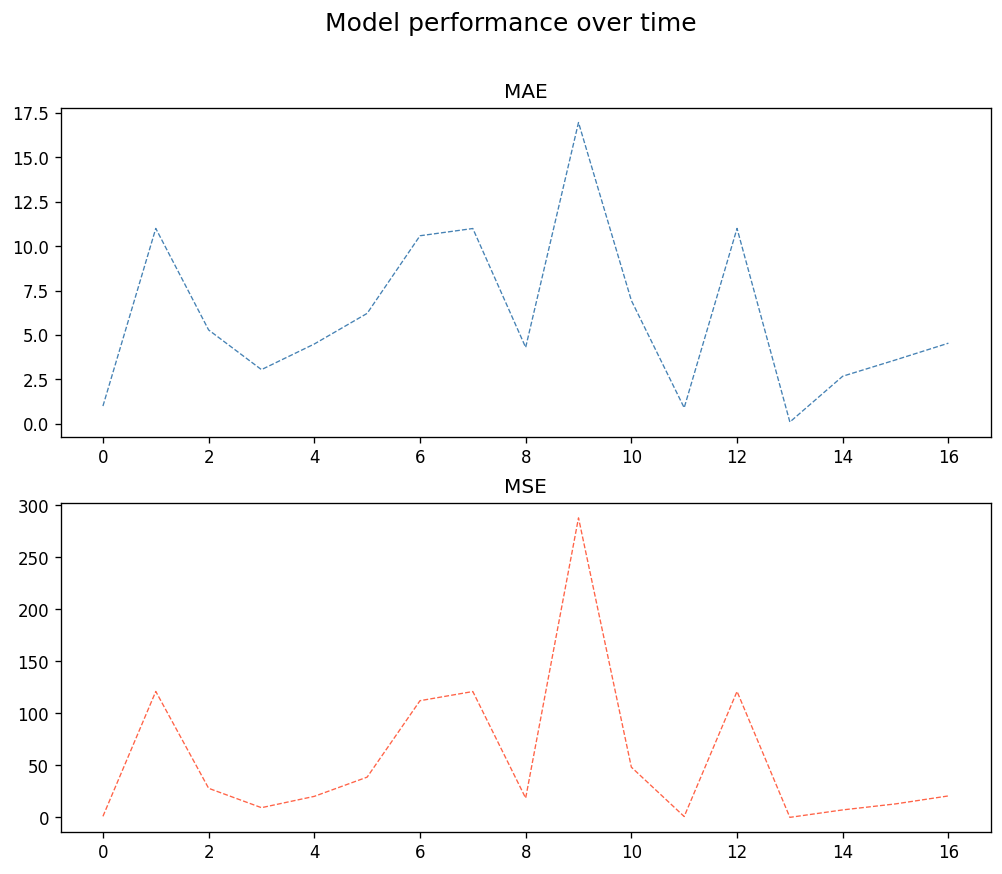

In [5]:
# Append metrics results on lists.
mae = []
mse = []
for i in range(len(results)):
    mae.append(results[i]['metrics']['mae'])
    mse.append(results[i]['metrics']['mse'])

# Generate figure.
fig, axs = plt.subplots(2, figsize=(10,8), dpi=120)

# Plots.
axs[0].plot(mae, linewidth=0.8, color='steelblue', linestyle='--')
axs[1].plot(mse, linewidth=0.8, color='tomato', linestyle='--')


# Set titles.
axs[0].set_title("MAE")
axs[1].set_title("MSE")
fig.suptitle('Model performance over time', fontsize=15)

plt.show()

Voilà!